In [53]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.impute import SimpleImputer    
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler,Binarizer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from xgboost import XGBRegressor    
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, KFold, RepeatedKFold 
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from catboost import CatBoostRegressor
from IPython.display import clear_output
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoCV
from sklearn.svm import SVR

In [54]:
data = pd.read_csv('data/train.csv')
original = pd.read_csv('archive/CrabAgePrediction.csv')
extended = pd.read_csv('extended/train_extended.csv')
synth1 = pd.read_csv('extended/synthetic_data1.csv')
synth2 = pd.read_csv('extended/synthetic_data2.csv')
synth3 = pd.read_csv('extended/synthetic_data3.csv')
test = pd.read_csv('data/test.csv')

In [55]:
extended.drop(extended[extended.Sex == '0.025' ].index, inplace=True)

In [56]:
extended.Sex.value_counts()

M    72270
I    66632
F    61097
Name: Sex, dtype: int64

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [58]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


In [59]:
extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              199999 non-null  int64  
 1   Sex             199999 non-null  object 
 2   Length          199999 non-null  float64
 3   Diameter        199999 non-null  float64
 4   Height          199999 non-null  float64
 5   Weight          199999 non-null  float64
 6   Shucked Weight  199999 non-null  float64
 7   Viscera Weight  199999 non-null  float64
 8   Shell Weight    199999 non-null  float64
 9   Age             199999 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 16.8+ MB


In [60]:
new_data = pd.concat([
                      data.drop('id', axis=1), 
                      original, 
                      extended.drop('id', axis=1), 
                      synth1.drop('id', axis=1),
                      synth2.drop('id', axis=1),
                      synth3.drop('id', axis=1),
                     ], 
                     ignore_index = True)
new_data.shape

(378943, 9)

In [61]:
new_data[new_data.Height == 0].count()

Sex               217
Length            217
Diameter          217
Height            217
Weight            217
Shucked Weight    217
Viscera Weight    217
Shell Weight      217
Age               217
dtype: int64

In [62]:
# new_data['Height'].replace(0.0,0.0125, inplace=True)
# new_data[new_data.Height == 0].count()

### EDA

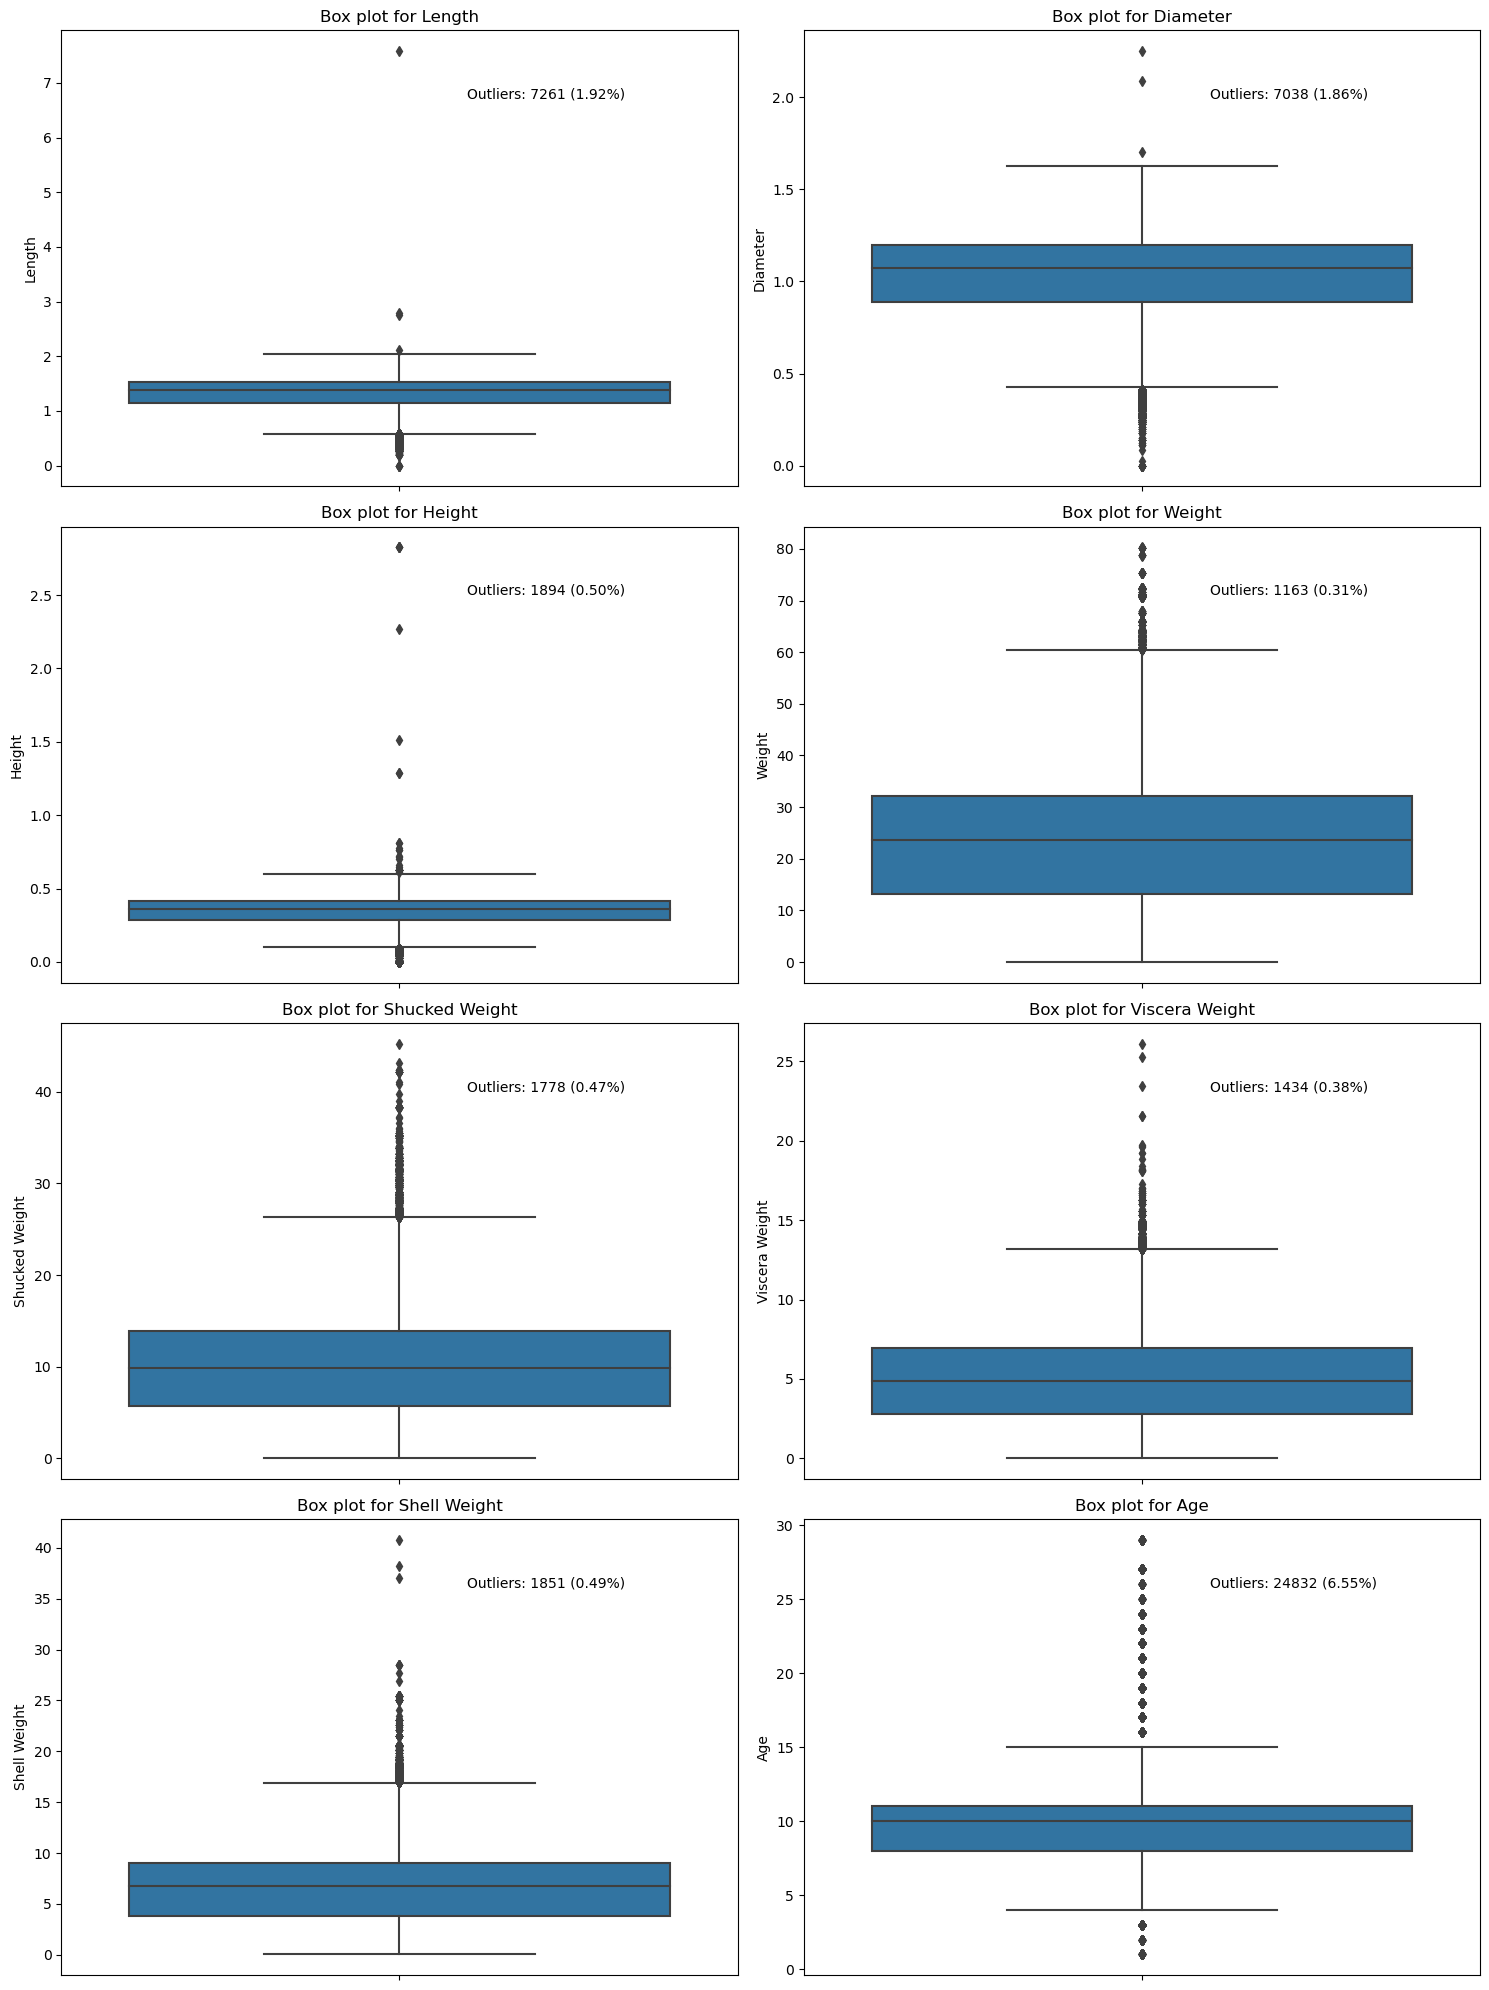

The feature with the most outliers is: Age with 24832 outliers.


In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and it only contains numerical columns
# If not, select only the numeric columns
df_numeric = new_data.select_dtypes(include=[np.number])

num_plots = len(df_numeric.columns)
num_cols = 2 # Define number of columns in your subplot grid
num_rows = num_plots//num_cols if num_plots%num_cols==0 else num_plots//num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5)) # Increase figure size here

outlier_dict = {}

for i, var in enumerate(df_numeric.columns):
    ax = axs.flatten()[i]
    sns.boxplot(y = var, data = df_numeric, ax=ax, orient='v')
    ax.set_title(f'Box plot for {var}') # Add title to each subplot
    
    # calculate interquartile range
    q1 = df_numeric[var].quantile(0.25)
    q3 = df_numeric[var].quantile(0.75)
    iqr = q3 - q1
    
    # calculate the outlier cutoff
    cutoff = iqr * 1.5
    lower, upper = q1 - cutoff, q3 + cutoff
    
    # identify outliers
    outliers = [x for x in df_numeric[var] if x < lower or x > upper]
    outlier_dict[var] = len(outliers)
    
    # annotate the subplot with the outlier percentage
    ax.annotate(f'Outliers: {len(outliers)} ({len(outliers)*100/len(df_numeric[var]):.2f}%)', xy=(0.6, 0.85), xycoords=ax.transAxes)

# If the number of columns is not a multiple of the number of rows, 
# delete any unused subplots
if num_plots % num_cols != 0:
    for idx in range(num_plots, num_rows*num_cols):
        fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

# Determine the feature with the most outliers
most_outliers_feature = max(outlier_dict, key=outlier_dict.get)
print(f"The feature with the most outliers is: {most_outliers_feature} with {outlier_dict[most_outliers_feature]} outliers.")


In [64]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378943 entries, 0 to 378942
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Sex             378943 non-null  object 
 1   Length          378943 non-null  float64
 2   Diameter        378943 non-null  float64
 3   Height          378943 non-null  float64
 4   Weight          378943 non-null  float64
 5   Shucked Weight  378943 non-null  float64
 6   Viscera Weight  378943 non-null  float64
 7   Shell Weight    378943 non-null  float64
 8   Age             378943 non-null  float64
dtypes: float64(8), object(1)
memory usage: 26.0+ MB


In [65]:
# Drop all duplicates in the DataFrame
new_data = new_data.drop_duplicates()

In [66]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378189 entries, 0 to 378942
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Sex             378189 non-null  object 
 1   Length          378189 non-null  float64
 2   Diameter        378189 non-null  float64
 3   Height          378189 non-null  float64
 4   Weight          378189 non-null  float64
 5   Shucked Weight  378189 non-null  float64
 6   Viscera Weight  378189 non-null  float64
 7   Shell Weight    378189 non-null  float64
 8   Age             378189 non-null  float64
dtypes: float64(8), object(1)
memory usage: 28.9+ MB


In [68]:
def engineer_features(df):


    condition1 = df['Weight']<(df['Shell Weight']+df['Viscera Weight']+df['Shucked Weight'])
    new_value = df['Shell Weight']+df['Viscera Weight']+df['Shucked Weight']
    df['Weight'] = np.where(condition1,new_value,df['Weight'])
    df["Area_Crab"]=df["Length"]*df["Diameter"]
    df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
    df ["D1"] = df["Height"] * df["Diameter"] 
    df ["D2"] = df["Height"] * df["Length"] 
    df ["D3"] = df["Diameter"] * df["Length"]
    
    df ["Volume"] = df["Weight"] / (df["Diameter"] + 1e-8 )
    df["total_weight"] = df["Shell Weight"] + df["Viscera Weight"] + df["Shucked Weight"]
    df['Shell Percentage'] = df['Shell Weight'] / df['Weight']
    df['Meat Percentage'] = df['Shucked Weight'] / df['Weight']
    df['Viscera Percentage'] = df['Viscera Weight'] / df['Weight']
    df['Shell Surface Area'] = (df['Diameter'] * df['Length'] * 2) * (
            df['Diameter'] * df['Height'] * 2) * (
                                       df['Length'] * df['Height'] * 2)
  
    df['L2'] = df['Length']**2
    df['H2'] = df['Height']**2
    df['W2'] = df['Weight']**2
    df['SW2'] = df['Shell Weight']**2
    df['SSW'] = np.sqrt(df['Shell Weight'])
    df['SSuW'] = np.sqrt(df['Shucked Weight'])
    df['SVW'] = np.sqrt(df['Viscera Weight'])
    
    df['Meat Yield'] = df['Shucked Weight'] / (df['Weight'] + df['Shell Weight'])
    df['Shell Ratio'] = df['Shell Weight'] / df['Weight']
    df['Weight_to_Shucked_Weight'] = df['Weight'] / df['Shucked Weight']
    df['Viscera Ratio'] = df['Viscera Weight'] / df['Weight']
    
    
    allcols = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Meat Yield','Shell Ratio', 
          'Weight_to_Shucked_Weight', 'Viscera Ratio']
    
    for i in allcols:
        df[i+' _log'] = (df[i]+1).transform(np.log)
        
    return df

In [69]:
new_data = engineer_features(new_data)

In [70]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378189 entries, 0 to 378942
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Sex                            378189 non-null  object 
 1   Length                         378189 non-null  float64
 2   Diameter                       378189 non-null  float64
 3   Height                         378189 non-null  float64
 4   Weight                         378189 non-null  float64
 5   Shucked Weight                 378189 non-null  float64
 6   Viscera Weight                 378189 non-null  float64
 7   Shell Weight                   378189 non-null  float64
 8   Age                            378189 non-null  float64
 9   Area_Crab                      378189 non-null  float64
 10  Volume                         378189 non-null  float64
 11  D1                             378189 non-null  float64
 12  D2                            

This code block calculates the correlation matrix of a dataframe `new_data` and then creates a heatmap visualization of the matrix using the seaborn library. Only correlations with absolute values greater than 0.7 are displayed. Let's break it down:

C:\Users\RAHUL DATTA\AppData\Local\Temp\ipykernel_30860\1573560989.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = new_data.corr()


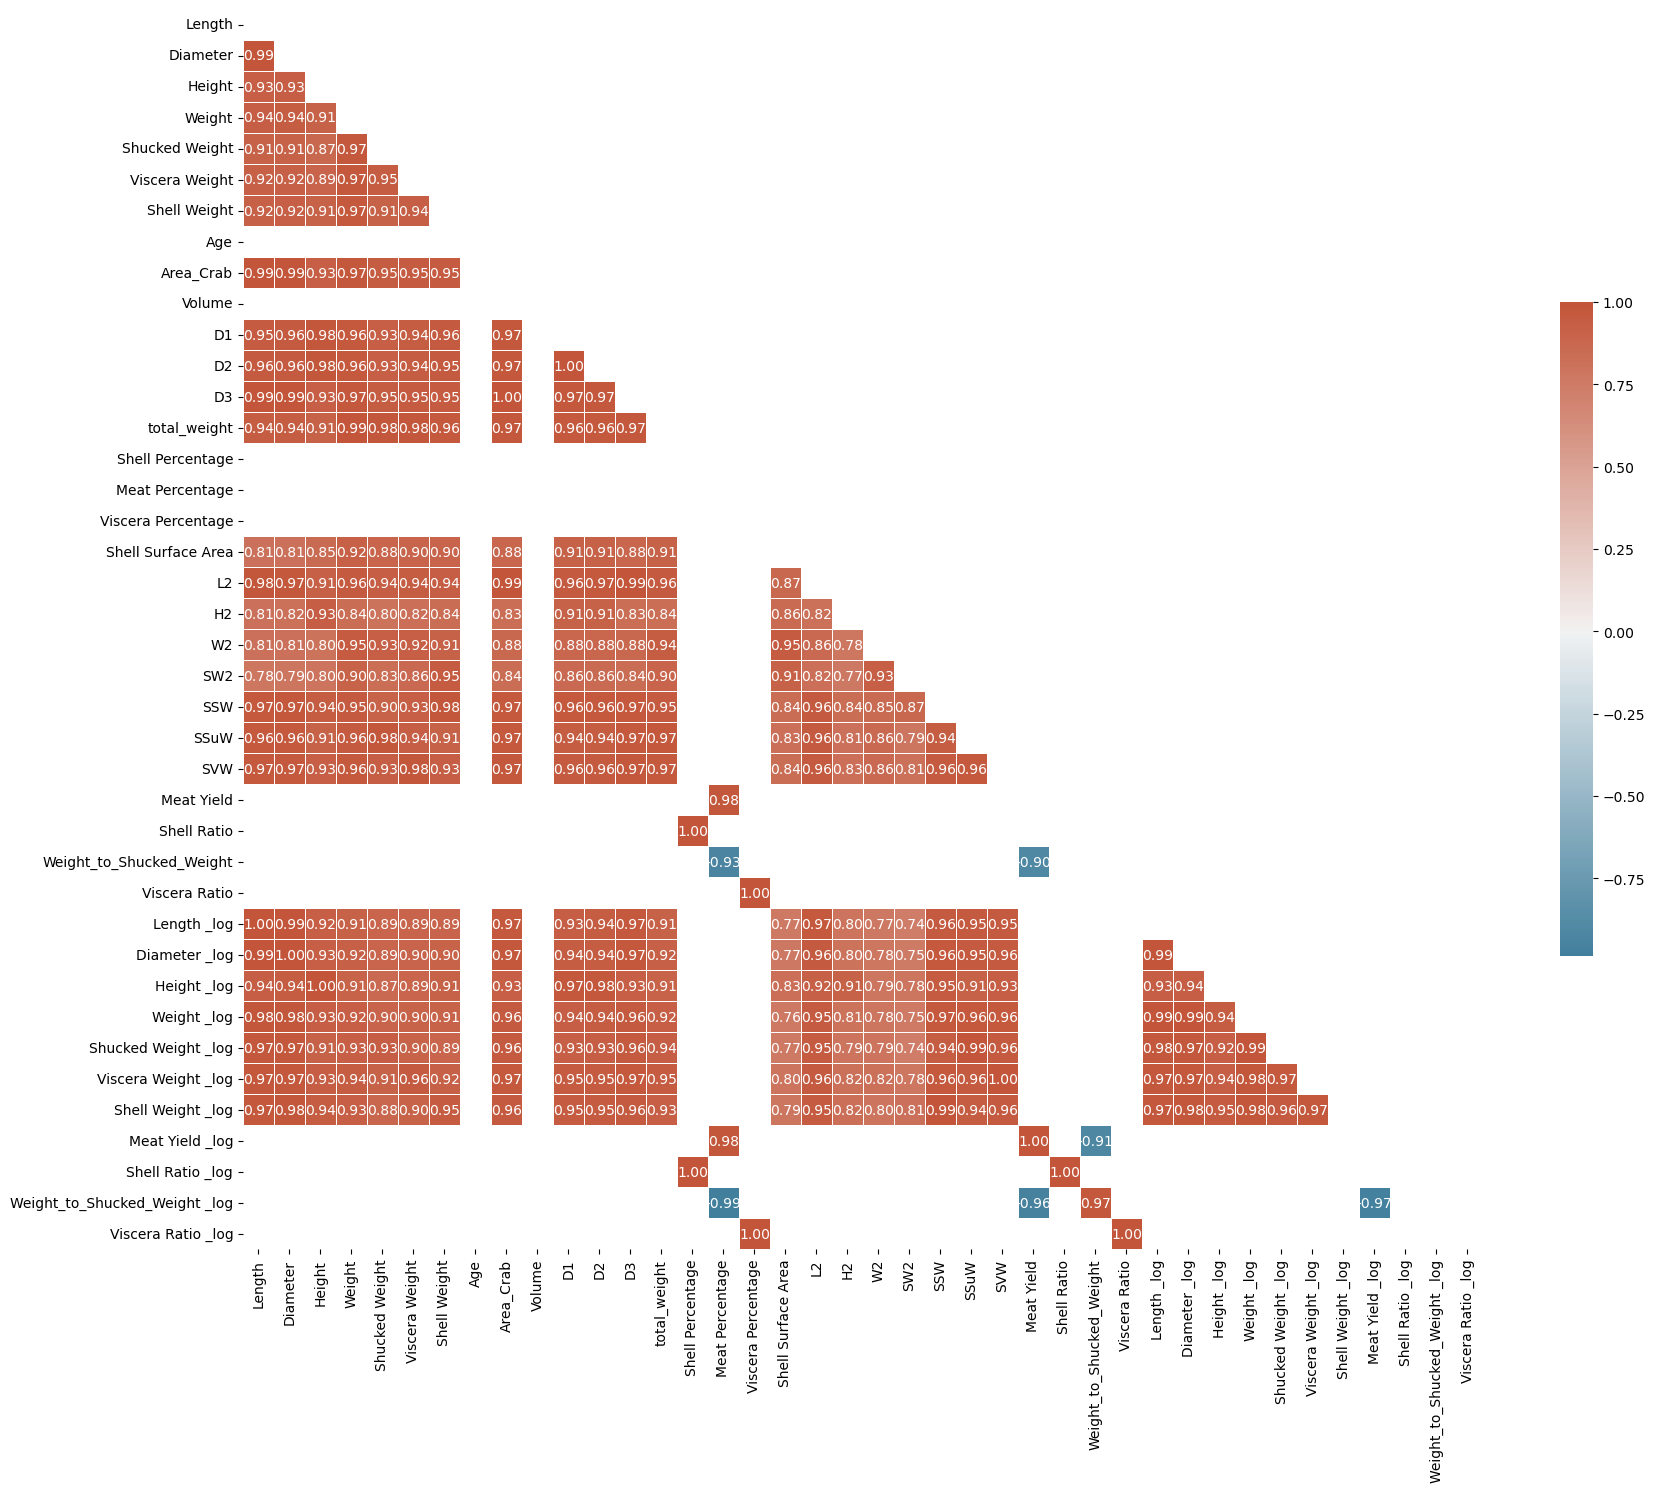

In [103]:
# Let's assume df is your DataFrame
corr = new_data.corr()

# Create a mask for your criterion
mask = np.abs(corr) > 0.7

# Create a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(20,17))

# Draw the heatmap
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)) | ~mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.show()


In [72]:
for col in new_data.columns:
    if new_data[col].dtype == np.float64:
        new_data[col] = new_data[col].astype(np.float32)

In [73]:
X = new_data.drop(columns=['Age'])
y = np.log(new_data['Age'])

In [74]:
# Get numerical and categorical columns
num_columns = list(X.select_dtypes(exclude='object').columns)
cat_columns = list(X.select_dtypes(include='object').columns)

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
X_train.shape, X_test.shape

((302551, 40), (75638, 40))

1. **%%time**: This is a magic command in Jupyter notebook used to measure the execution time of the cell script.

2. **num_pipe**: This is a pipeline defined to preprocess numerical columns. It applies a Yeo-Johnson power transformation (adjusts the data distribution to be more Gaussian-like, dealing with skewness), creates polynomial features of degree 2 with interaction terms only, and scales the values using `MaxAbsScaler()` which scales the values based on the absolute maximum.

3. **preprocessor**: This is a `ColumnTransformer` defined to apply the numerical and categorical preprocessing pipelines to the appropriate columns in a dataset (`num_columns` and `cat_columns`).

4. **preprocessing_steps**: This bundles the preprocessing steps into a list. 

5. **XGBoost pipelines creation**: Four different pipelines are created, each containing preprocessing steps and an XGBoost Regressor model, each with a unique name ('xgb1', 'xgb2', etc). These models are using the GPU-accelerated 'gpu_hist' method for faster computations.

6. **xgb_params**: This is the list of parameters to use for grid search optimization of each XGBoost model. It includes hyperparameters like the number of trees (`n_estimators`), maximum depth of each tree (`max_depth`), learning rate, and more.

7. **KFold object**: A KFold object is created for performing cross-validation during grid search. 

8. **Grid search for each XGBRegressor**: Each of the XGBoost pipelines is optimized using grid search with the specified parameters. The `GridSearchCV` finds the best parameters from the grid search and fits the best model on the training data. The best estimator (model) from each grid search is stored in the `xgb_optimized_models` list.

9. **StackingRegressor**: This is a `StackingRegressor` created which uses the optimized XGBoost models as base learners and a LightGBM Regressor as the final (meta) estimator. Stacking is an ensemble learning technique that uses predictions from multiple models (called base learners) to build a new model (called meta learner or final estimator) which makes final predictions. 

10. **Fitting the stacking regressor**: The stacking regressor is then fit to the training data.

In summary, this script performs a complex machine learning task involving several stages of data preprocessing, hyperparameter tuning, and ensemble learning with multiple models. The aim is to predict a target variable using a range of features, using a stacking ensemble of XGBoost models with a LightGBM as the final estimator.


In [77]:
%%time

# Define preprocessing for numerical columns (create polynomial features then scale)
num_pipe = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson')),
#     ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', RobustScaler()),
])

# Update your preprocessor to use this pipeline for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_columns),
        ('cat', OneHotEncoder(handle_unknown="ignore"), cat_columns)
    ])

# Define preprocessing steps
preprocessing_steps = [('Preprocessor', preprocessor)]

# Define pipeline for XGBRegressor with different hyperparameters
xgb_pipes = []
for i in range(3):
    xgb_pipe = Pipeline(steps=preprocessing_steps + [('xgb'+str(i+1), XGBRegressor(random_state=42, 
                                                                                   tree_method='gpu_hist'))])
    xgb_pipes.append(xgb_pipe)
    
# Define hyperparameters for each XGBRegressor
xgb_params = [
    {
    'xgb1__n_estimators': [600],
    'xgb1__max_depth': [7],
    'xgb1__learning_rate': [0.01],
    'xgb1__subsample': [0.8],
    'xgb1__tree_method': ['gpu_hist'],
    'xgb1__min_child_weight': [1],
    'xgb1__gamma': [0.5],
    'xgb1__colsample_bytree': [0.4],
    'xgb1__eval_metric': ["mae"],
    'xgb1__reg_alpha': [1],
    'xgb1__reg_lambda': [1],
    'xgb1__gpu_id' : ['0'],
    'xgb1__predictor' : ["gpu_predictor"]
},
    {
    'xgb2__n_estimators': [1000],
    'xgb2__max_depth': [10],
    'xgb2__learning_rate': [0.02],
    'xgb2__subsample': [0.9],
    'xgb2__tree_method': ['gpu_hist'],
    'xgb2__min_child_weight': [5], 
    'xgb2__gamma': [1],
    'xgb2__colsample_bytree': [0.6],
    'xgb2__eval_metric': ["mae"],
    'xgb2__reg_alpha': [0],
    'xgb2__reg_lambda': [0],
    'xgb2__gpu_id' : ['0'],
    'xgb2__predictor' : ["gpu_predictor"]
},
    {
    'xgb3__n_estimators': [1500],
    'xgb3__max_depth': [5, 10],
    'xgb3__learning_rate': [0.03],
    'xgb3__subsample': [0.5],
    'xgb3__tree_method': ['gpu_hist'],
    'xgb3__min_child_weight': [8], 
    'xgb3__gamma': [1.5],
    'xgb3__colsample_bytree': [0.8],
    'xgb3__eval_metric': ["mae"],
    'xgb3__reg_alpha': [3],
    'xgb3__reg_lambda': [6],
    'xgb3__gpu_id' : ['0'],
    'xgb3__predictor' : ["gpu_predictor"]
}
    
]

cb_params = {'cb__learning_rate': [0.1, 0.01],
             'cb__depth': [6, 8],
             'cb__l2_leaf_reg': [1, 3, 5],
             'cb__iterations': [200, 500],
             'cb__eval_metric': ['mae'],
            }


kFold = KFold(n_splits=5)

xgb_optimized_models = []

# Grid search for each XGBRegressor
for i in range(len(xgb_pipes)):
    xgb_optimized = GridSearchCV(xgb_pipes[i], 
                                 xgb_params[i], 
                                 scoring='neg_mean_absolute_error',                                 
                                 cv=kFold,                                 
                                 verbose=3,
                                 n_jobs=1,
                                 )
    xgb_optimized.fit(X_train, y_train)
    xgb_optimized_models.append(('xgb'+str(i+1), xgb_optimized.best_estimator_))


# Use the optimized XGBRegressor models in the stacking ensemble
stacking_regressor = StackingRegressor(
    estimators=xgb_optimized_models, 
    final_estimator=lgb.LGBMRegressor(n_estimators=600, objective = "regression_l1", metric='mae'),  
    cv=10,
    n_jobs=None,
    verbose=3,    
)

# Fit the stacking regressor
stacking_regressor.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END xgb1__colsample_bytree=0.4, xgb1__eval_metric=mae, xgb1__gamma=0.5, xgb1__gpu_id=0, xgb1__learning_rate=0.01, xgb1__max_depth=7, xgb1__min_child_weight=1, xgb1__n_estimators=600, xgb1__predictor=gpu_predictor, xgb1__reg_alpha=1, xgb1__reg_lambda=1, xgb1__subsample=0.8, xgb1__tree_method=gpu_hist;, score=-0.128 total time=   4.6s
[CV 2/5] END xgb1__colsample_bytree=0.4, xgb1__eval_metric=mae, xgb1__gamma=0.5, xgb1__gpu_id=0, xgb1__learning_rate=0.01, xgb1__max_depth=7, xgb1__min_child_weight=1, xgb1__n_estimators=600, xgb1__predictor=gpu_predictor, xgb1__reg_alpha=1, xgb1__reg_lambda=1, xgb1__subsample=0.8, xgb1__tree_method=gpu_hist;, score=-0.127 total time=   4.3s
[CV 3/5] END xgb1__colsample_bytree=0.4, xgb1__eval_metric=mae, xgb1__gamma=0.5, xgb1__gpu_id=0, xgb1__learning_rate=0.01, xgb1__max_depth=7, xgb1__min_child_weight=1, xgb1__n_estimators=600, xgb1__predictor=gpu_predictor, xgb1__reg_alpha=1, xgb1__reg_l

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   44.0s finished


CPU times: total: 7min 53s
Wall time: 4min 11s


StackingRegressor(cv=10,
                  estimators=[('xgb1',
                               Pipeline(steps=[('Preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('scaler',
                                                                                                  RobustScaler())]),
                                                                                 ['Length',
                                                                                  'Diameter',
                                                                                  'Height',
                                                                                  'Weight',
                                                                                  'Shucked '
                                                                                  'Weight',
                                                                                  'Viscera '
                                                                                  'Weight',
                                                                                  'Shell '
                                                                                  'Weight',
                                                                                  'Area_Crab',
                                                                                  'Volume',
                                                                                  'D1',
                                                                                  'D2',
                                                                                  'D3',
                                                                                  'total_weight',
                                                                                  'Shell '
                                                                                  'Percentage',
                                                                                  'Meat '
                                                                                  'Percentage',
                                                                                  'Viscera '
                                                                                  '...
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=10,
                                                             max_leaves=None,
                                                             min_child_weight=8,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=1500,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor='gpu_predictor',
                                                             random_state=42, ...))]))],
                  final_estimator=LGBMRegressor(metric='mae', n_estimators=600,
                                                objective='regression_l1'),
                  verbose=3)

In [98]:
error_analysis = True

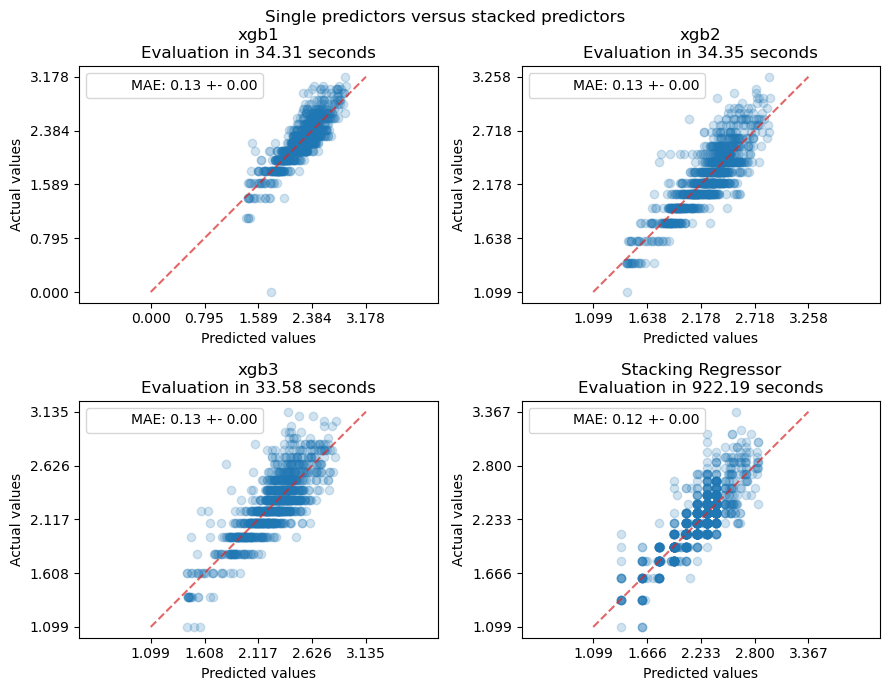

In [99]:
if error_analysis:
    import time
    import matplotlib.pyplot as plt
    from sklearn.metrics import PredictionErrorDisplay
    from sklearn.model_selection import cross_validate, cross_val_predict

    fig, axs = plt.subplots(2, 2, figsize=(9, 7))
    axs = np.ravel(axs)

    for ax, (name, est) in zip(
        axs, xgb_optimized_models + [("Stacking Regressor", stacking_regressor)]
    ):
        scorers = {"MAE": "neg_mean_absolute_error"}

        start_time = time.time()
        scores = cross_validate(
            est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
        )
        elapsed_time = time.time() - start_time

        y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
        scores = {
            key: (
                f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
                f"{np.std(scores[f'test_{value}']):.2f}"
            )
            for key, value in scorers.items()
        }

        display = PredictionErrorDisplay.from_predictions(
            y_true=y,
            y_pred=y_pred,
            kind="actual_vs_predicted",
            ax=ax,
            scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
            line_kwargs={"color": "tab:red"},
        )
        ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

        for name, score in scores.items():
            ax.plot([], [], " ", label=f"{name}: {score}")
        ax.legend(loc="upper left")

    plt.suptitle("Single predictors versus stacked predictors")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

This Python code measures and visualizes the performance of a `StackingRegressor` model using learning curves. The function `plot_learning_curve` is defined to generate a plot where the x-axis represents the number of training examples and the y-axis represents the model's score (accuracy). It plots both the training score and the cross-validation score as a function of the number of training examples. The shaded regions indicate the variability of the scores (one standard deviation). The function is then used to plot the learning curve for a `StackingRegressor`, using 5-fold cross-validation. 

**This visualization can be useful in understanding overfitting/underfitting patterns.**

### Error Analysis

[learning_curve] Training set sizes: [ 30255  98329 166403 234477 302551]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   50.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.

[CV] END ..................., score=(train=0.696, test=0.664) total time= 2.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21

[CV] END ..................., score=(train=0.698, test=0.663) total time= 1.5min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   31.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29

[CV] END ..................., score=(train=0.700, test=0.665) total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   40.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   36.0s finished


[CV] END ..................., score=(train=0.702, test=0.667) total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   47.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   43.4s finished


[CV] END ..................., score=(train=0.702, test=0.666) total time= 2.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.7s finished


[CV] END ..................., score=(train=0.672, test=0.688) total time=  45.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.9s finished


[CV] END ..................., score=(train=0.676, test=0.693) total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.7s finished


[CV] END ..................., score=(train=0.686, test=0.695) total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.7s finished


[CV] END ..................., score=(train=0.691, test=0.695) total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   43.8s finished


[CV] END ..................., score=(train=0.693, test=0.696) total time= 2.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.6s finished


[CV] END ..................., score=(train=0.672, test=0.690) total time=  44.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.7s finished


[CV] END ..................., score=(train=0.674, test=0.693) total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.5s finished


[CV] END ..................., score=(train=0.685, test=0.697) total time= 1.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   37.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   36.4s finished


[CV] END ..................., score=(train=0.690, test=0.699) total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   44.2s finished


[CV] END ..................., score=(train=0.694, test=0.700) total time= 2.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.1s finished


[CV] END ..................., score=(train=0.672, test=0.687) total time=  43.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.9s finished


[CV] END ..................., score=(train=0.674, test=0.690) total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.0s finished


[CV] END ..................., score=(train=0.685, test=0.693) total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   37.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   36.0s finished


[CV] END ..................., score=(train=0.690, test=0.693) total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   48.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   43.7s finished


[CV] END ..................., score=(train=0.695, test=0.697) total time= 2.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


[CV] END ..................., score=(train=0.672, test=0.690) total time=  44.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.5s finished


[CV] END ..................., score=(train=0.674, test=0.693) total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.1s finished


[CV] END ..................., score=(train=0.685, test=0.695) total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   37.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.9s finished


[CV] END ..................., score=(train=0.691, test=0.697) total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   47.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   43.3s finished


[CV] END ..................., score=(train=0.692, test=0.697) total time= 2.6min
CPU times: total: 1h 39min 9s
Wall time: 44min 41s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 44.7min finished


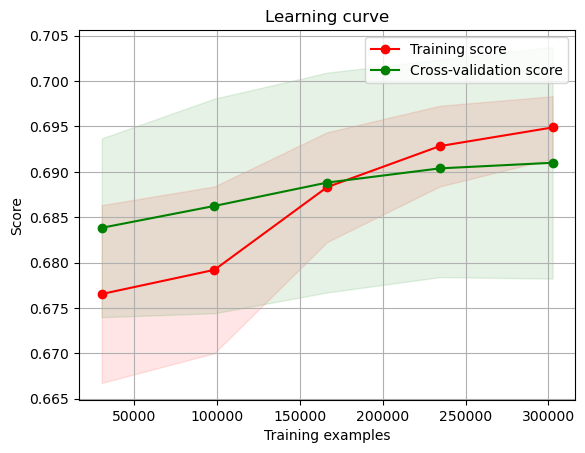

In [100]:
%%time

if error_analysis:
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt

    # Define a function to plot learning curves
    def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=3)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
        plt.legend(loc="best")
        return plt

    # Generate the plot
    plot_learning_curve(stacking_regressor, "Learning curve", X, y, cv=KFold(n_splits=5))

In [82]:
y_pred = stacking_regressor.predict(X_test)
errors = abs(y_test - y_pred)

This can give you an idea about the distribution of errors (are they normal, skewed, etc.).

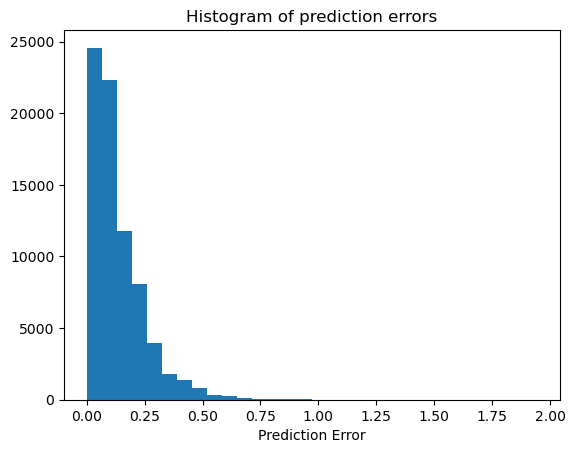

In [83]:
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error')
plt.title('Histogram of prediction errors')
plt.show()

In [84]:
from scipy.stats import skew
skew(errors)

1.9004474969480663

Identifying instances with high error:

In [85]:
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': errors})
error_df.sort_values('Error', ascending=False, inplace=True)

Analyzing residuals vs. predicted plot.
    - A residuals vs. predicted plot can provide insight into whether my model 
      is systematically over or underpredicting at certain levels of the dependent variable.

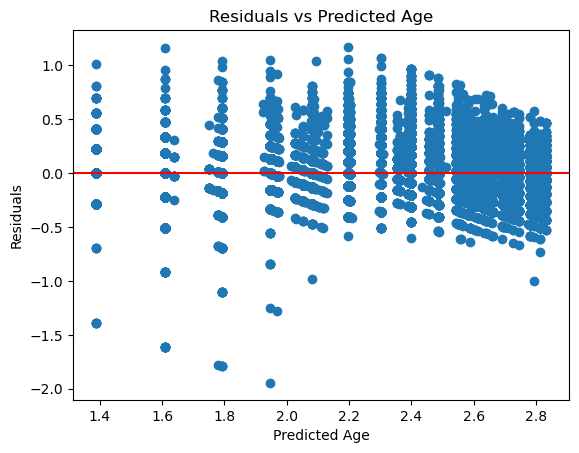

In [86]:
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel('Predicted Age')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Predicted Age')
plt.show()

Errors across different groups

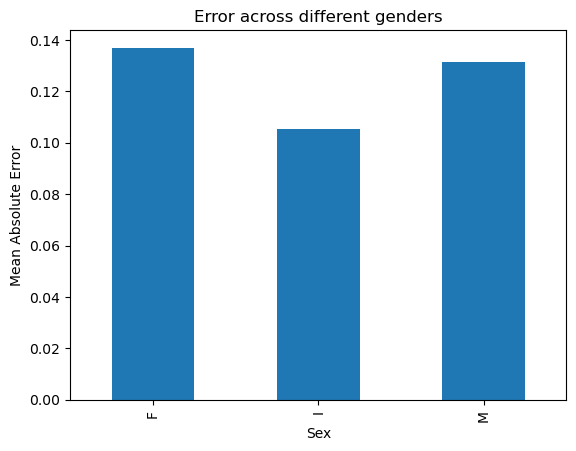

In [87]:
error_df = X_test.copy()
error_df['Error'] = errors
error_df.groupby('Sex')['Error'].mean().plot(kind='bar')
plt.ylabel('Mean Absolute Error')
plt.title('Error across different genders')
plt.show()

Since there are very few amount of unique values among our target, we can try using post-processing by rounding our prediction to the closest unique value.

In [88]:
def postprocessor(prediction):
    unique_targets = np.unique(data['Age'])
    return [min(unique_targets, key = lambda x: abs(x - pred)) for pred in prediction]

Generating Submission file

In [91]:
test[test.Height == 0 ].count()

id                14
Sex               14
Length            14
Diameter          14
Height            14
Weight            14
Shucked Weight    14
Viscera Weight    14
Shell Weight      14
dtype: int64

In [92]:
ids = test.id
test = engineer_features(test)
y_pred = stacking_regressor.predict(test)
y_pred = np.exp(y_pred)

In [94]:
y_pred = np.round(y_pred)

Rounding to nearest Age considering train

In [93]:
y_pred_new = postprocessor(y_pred)

Check If both are matching

In [95]:
np.sum((y_pred == y_pred_new))

49368

Since both are matching take any one of them

In [96]:
submission1 = pd.DataFrame({'id':ids, 'Age': y_pred})
submission1.to_csv('submission_stacks_closing.csv', index=False)

In [97]:
submission1.head(9729)

,id,Age
0,74051,8.0
1,74052,8.0
2,74053,10.0
3,74054,9.0
4,74055,7.0
...,...,...
9724,83775,8.0
9725,83776,7.0
9726,83777,9.0
9727,83778,9.0
